In [1]:
# On importe toutes les bibliothèques utile pour ce projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from time import time

from functions import *

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn import decomposition, preprocessing

# Nettoyage et préparation des données

In [2]:
# On importe tous les jeux de données nécéssaires
articles_metadata = pd.read_csv('datas/articles_metadata.csv')
clicks_sample = pd.read_csv('datas/clicks_sample.csv')

In [3]:
# Récupération des données de tous les fichiers du dossier clicks
# Chemin vers le dossier contenant les fichiers CSV
dossier = "datas/clicks"

# Liste pour stocker les DataFrames de chaque fichier CSV
dfs = []

# Parcourir tous les fichiers dans le dossier
for fichier in os.listdir(dossier):
    if fichier.endswith(".csv"):
        # Lire le fichier CSV et ajouter le DataFrame à la liste
        chemin_fichier = os.path.join(dossier, fichier)
        df = pd.read_csv(chemin_fichier)
        dfs.append(df)

# Concaténer tous les DataFrames en un seul
clicks = pd.concat(dfs, ignore_index=True)

# Afficher les premières lignes du DataFrame final
print(clicks.head())

  user_id        session_id  session_start session_size click_article_id  \
0       0  1506825423271737  1506825423000            2           157541   
1       0  1506825423271737  1506825423000            2            68866   
2       1  1506825426267738  1506825426000            2           235840   
3       1  1506825426267738  1506825426000            2            96663   
4       2  1506825435299739  1506825435000            2           119592   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1506826828020                 4                 3       20             1   
1   1506826858020                 4                 3       20             1   
2   1506827017951                 4                 1       17             1   
3   1506827047951                 4                 1       17             1   
4   1506827090575                 4                 1       17             1   

  click_region click_referrer_type  
0           20           

In [4]:
# .info() du dataframe articles_metadata (NB de nulles, NB valeurs totales, ....
print("articles_metadata :")
articles_metadata.info()

articles_metadata :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


In [5]:
# .describe() du dataframe articles_metadata (NB de nulles, NB valeurs totales, ....
print("articles_metadata :")
articles_metadata.describe()

articles_metadata :


,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


In [6]:
# On observe grâce au describe de la table que la colonne publisher_id contient une seule et même valeur 0
# On va donc supprimer cette colonne
articles_metadata = articles_metadata.drop('publisher_id', axis=1)
articles_metadata

,article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
...,...,...,...,...
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126


In [7]:
# On récupère les articles qui ont un valeur = 0 dans la colonne qui représente le nombre de mots (Words_count)
art_sans_mots = articles_metadata[articles_metadata['words_count'] == 0]
print(art_sans_mots.info())
art_sans_mots

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 35491 to 333154
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   article_id     35 non-null     int64
 1   category_id    35 non-null     int64
 2   created_at_ts  35 non-null     int64
 3   words_count    35 non-null     int64
dtypes: int64(4)
memory usage: 1.4 KB
None


,article_id,category_id,created_at_ts,words_count
35491,35491,43,1470303722000,0
38472,38472,51,1303420963000,0
39043,39043,64,1404158555000,0
39054,39054,64,1421875833000,0
164414,164414,288,1427704223000,0
206233,206233,331,1506791516000,0
212323,212323,343,1271673376000,0
212324,212324,343,1271443795000,0
212327,212327,343,1407788585000,0
212526,212526,347,1517168335000,0


In [8]:
# On supprime les article qui ont un nombre de mots = 0 car ce sont des raticles vides (35 lignes trouvées)
# Identifier les indices des lignes à supprimer
#indices_a_supprimer = articles_metadata.index[articles_metadata['words_count'] == 0].tolist()

# Supprimer les lignes avec la valeur 0 dans la colonne 'words_count'
#articles_metadata = articles_metadata.drop(indices_a_supprimer)

# Réindexer le DataFrame après la suppression
#articles_metadata = articles_metadata.reset_index(drop=True)
#articles_metadata

# On vérifie si le nombre de ligne du dataframe final correspond (364047 - 35 = 364012)

In [9]:
# .info() du dataframe clicks_sample (NB de nulles, NB valeurs totales, ....
print("clicks_sample :")
clicks_sample.info()

clicks_sample :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   user_id              1883 non-null   int64
 1   session_id           1883 non-null   int64
 2   session_start        1883 non-null   int64
 3   session_size         1883 non-null   int64
 4   click_article_id     1883 non-null   int64
 5   click_timestamp      1883 non-null   int64
 6   click_environment    1883 non-null   int64
 7   click_deviceGroup    1883 non-null   int64
 8   click_os             1883 non-null   int64
 9   click_country        1883 non-null   int64
 10  click_region         1883 non-null   int64
 11  click_referrer_type  1883 non-null   int64
dtypes: int64(12)
memory usage: 176.7 KB


In [10]:
# .describe() du dataframe clicks_sample (NB de nulles, NB valeurs totales, ....
print("clicks_sample :")
clicks_sample.describe()

clicks_sample :


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1883.000000,1.883000e+03,1.883000e+03,1883.000000,1883.000000,1.883000e+03,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,355.893787,1.506828e+15,1.506828e+12,3.459904,176717.848646,1.506830e+12,3.917153,2.305895,12.113648,1.491768,18.774827,1.764206
std,206.162865,8.679628e+08,8.679468e+05,3.037467,82324.177259,1.064938e+07,0.410461,1.062301,7.825735,2.007772,7.083400,1.225679
min,0.000000,1.506825e+15,1.506825e+12,2.000000,2137.000000,1.506827e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,181.500000,1.506827e+15,1.506827e+12,2.000000,108854.000000,1.506828e+12,4.000000,1.000000,2.000000,1.000000,13.000000,1.000000
50%,353.000000,1.506828e+15,1.506828e+12,3.000000,157541.000000,1.506828e+12,4.000000,3.000000,17.000000,1.000000,21.000000,1.000000
75%,537.000000,1.506828e+15,1.506828e+12,4.000000,236697.500000,1.506829e+12,4.000000,3.000000,19.000000,1.000000,25.000000,2.000000
max,706.000000,1.506829e+15,1.506829e+12,24.000000,363291.000000,1.506998e+12,4.000000,4.000000,20.000000,11.000000,28.000000,7.000000


In [11]:
# On transforme la valeur click_timestamp en format date pour que soit plus simple à utiliser ensuite
clicks_sample['click_date'] = pd.to_datetime(clicks_sample['click_timestamp'], unit='ms')
clicks_sample

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,click_date
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,2017-10-01 03:00:28.020
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,2017-10-01 03:00:58.020
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,2017-10-01 03:03:37.951
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,2017-10-01 03:04:07.951
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,2017-10-01 03:04:50.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2,2017-10-01 04:08:32.301
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2,2017-10-01 04:09:02.301
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1,2017-10-01 03:37:07.334
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1,2017-10-01 03:38:15.732


In [12]:
# Environ 3 millions de clics, répartis dans plus d'un million de sessions de 314 000 utilisateurs qui ont lu plus de 46 000 articles
#.info()
print("clicks :")
clicks.info()

clicks :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 273.6+ MB


In [13]:
# .describe()
print("clicks :")
clicks.describe()

clicks :


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181
unique,322897,1048594,646874,72,46033,2983198,3,5,8,11,28,7
top,5890,1507563657895091,1507563657000,2,160974,1506961009961,4,1,17,1,25,2
freq,1232,124,127,1260372,37213,3,2904478,1823162,1738138,2852406,804985,1602601


In [14]:
# On transforme la valeur click_timestamp en format date pour que soit plus simple à utiliser ensuite
clicks['click_date'] = pd.to_datetime(clicks['click_timestamp'], unit='ms')
clicks

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,click_date
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,2017-10-01 03:00:28.020
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,2017-10-01 03:00:58.020
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,2017-10-01 03:03:37.951
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,2017-10-01 03:04:07.951
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,2017-10-01 03:04:50.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1,2017-10-17 03:39:17.302
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2,2017-10-17 03:41:12.520
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2,2017-10-17 03:41:42.520
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2,2017-10-17 03:38:33.583


In [15]:
taux_valeurs_manquantes = round(clicks.isnull().mean() * 100, 1)
taux_valeurs_manquantes

user_id                0.0
session_id             0.0
session_start          0.0
session_size           0.0
click_article_id       0.0
click_timestamp        0.0
click_environment      0.0
click_deviceGroup      0.0
click_os               0.0
click_country          0.0
click_region           0.0
click_referrer_type    0.0
click_date             0.0
dtype: float64

In [16]:
# Lecture de l'objet sérialisé depuis le fichier .pickle
with open('datas/articles_embeddings.pickle', 'rb') as fichier:
    articles_embeddings = pickle.load(fichier)

print(articles_embeddings.shape)
print(articles_embeddings)

(364047, 250)
[[-0.16118301 -0.95723313 -0.13794445 ... -0.231686    0.5974159
   0.40962312]
 [-0.52321565 -0.974058    0.73860806 ...  0.18282819  0.39708954
  -0.83436364]
 [-0.61961854 -0.9729604  -0.20736018 ... -0.44758022  0.8059317
  -0.28528407]
 ...
 [-0.25139043 -0.9762427   0.58609664 ... -0.14372464  0.06809307
  -0.7050104 ]
 [ 0.22434181 -0.92328775 -0.38174152 ...  0.6871319  -0.5315117
   0.01072566]
 [-0.25713393 -0.9946313   0.9837918  ...  0.98387307 -0.8381829
  -0.1792827 ]]


### Merge entre l'échantillon des clicks et les articles

In [17]:
merged_data = pd.merge(articles_metadata, clicks_sample, how='inner', left_on="article_id",
                  right_on='click_article_id', indicator='merge')

In [18]:
merged_data['merge'].value_counts()

merge
both          1883
left_only        0
right_only       0
Name: count, dtype: int64

In [19]:
merged_data_V2 = pd.merge(articles_metadata, clicks, how='inner', left_on="article_id",
                  right_on='click_article_id', indicator='merge_V2')

In [20]:
merged_data_V2['merge_V2'].value_counts()

merge_V2
both          2988181
left_only           0
right_only          0
Name: count, dtype: int64

In [21]:
merged_data_V2

,article_id,category_id,created_at_ts,words_count,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,click_date,merge_V2
0,3,1,1408468313000,230,246630,1507569563229379,1507569563000,2,3,1507572378399,4,1,17,1,8,5,2017-10-09 18:06:18.399,both
1,27,1,1478811408000,151,58062,1507144774359237,1507144774000,2,27,1507144866293,4,1,17,1,25,1,2017-10-04 19:21:06.293,both
2,69,1,1368528105000,290,289974,1507830296148001,1507830296000,3,69,1507832069718,4,1,17,1,25,5,2017-10-12 18:14:29.718,both
3,81,1,1371658109000,202,65902,1506954258239649,1506954258000,2,81,1506954288811,4,1,17,1,2,5,2017-10-02 14:24:48.811,both
4,81,1,1371658109000,202,56070,1506973960396557,1506973960000,5,81,1506974215111,4,1,17,1,7,1,2017-10-02 19:56:55.111,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,364043,460,1434148472000,463,277901,1507735183261490,1507735183000,2,364043,1507735330786,1,3,2,1,5,5,2017-10-11 15:22:10.786,both
2988177,364043,460,1434148472000,463,317423,1508162689427357,1508162689000,3,364043,1508163146474,4,1,17,1,21,5,2017-10-16 14:12:26.474,both
2988178,364043,460,1434148472000,463,93792,1508181012401212,1508181012000,2,364043,1508181241509,4,3,2,1,13,2,2017-10-16 19:14:01.509,both
2988179,364046,460,1505811330000,479,126974,1507037126358841,1507037126000,3,364046,1507037561633,4,1,17,1,21,1,2017-10-03 13:32:41.633,both


In [22]:
# Limiter le nombre de lignes à 2,000,000
clicks_sample = clicks.sample(n=2500000, random_state=42)

In [23]:
merged_data_V3 = pd.merge(articles_metadata, clicks_sample, how='inner', left_on="article_id",
                  right_on='click_article_id', indicator='merge_V3')

In [24]:
merged_data_V3['merge_V3'].value_counts()

merge_V3
both          2500000
left_only           0
right_only          0
Name: count, dtype: int64

In [25]:
merged_data_V3

,article_id,category_id,created_at_ts,words_count,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,click_date,merge_V3
0,3,1,1408468313000,230,246630,1507569563229379,1507569563000,2,3,1507572378399,4,1,17,1,8,5,2017-10-09 18:06:18.399,both
1,27,1,1478811408000,151,58062,1507144774359237,1507144774000,2,27,1507144866293,4,1,17,1,25,1,2017-10-04 19:21:06.293,both
2,69,1,1368528105000,290,289974,1507830296148001,1507830296000,3,69,1507832069718,4,1,17,1,25,5,2017-10-12 18:14:29.718,both
3,81,1,1371658109000,202,65902,1506954258239649,1506954258000,2,81,1506954288811,4,1,17,1,2,5,2017-10-02 14:24:48.811,both
4,84,1,1371821736000,158,190073,1507560485307307,1507560485000,4,84,1507560485152,4,1,17,1,1,5,2017-10-09 14:48:05.152,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499995,364043,460,1434148472000,463,19864,1507218684220697,1507218684000,25,364043,1507231045481,4,1,17,1,13,5,2017-10-05 19:17:25.481,both
2499996,364043,460,1434148472000,463,277901,1507735183261490,1507735183000,2,364043,1507735330786,1,3,2,1,5,5,2017-10-11 15:22:10.786,both
2499997,364043,460,1434148472000,463,222064,1507562425198479,1507562425000,2,364043,1507565830788,4,1,12,1,25,1,2017-10-09 16:17:10.788,both
2499998,364043,460,1434148472000,463,593,1507395987164884,1507395987000,2,364043,1507396034508,4,1,17,1,6,1,2017-10-07 17:07:14.508,both


### Le nombre de clics par date

In [26]:
# On regroupe par date pour avoiçr le nombre de clics par date
clicks_per_date = merged_data_V3.groupby(merged_data_V3['click_date'].dt.date).size().reset_index(name='clicks')
clicks_per_date

,click_date,clicks
0,2017-10-01,78517
1,2017-10-02,253810
2,2017-10-03,218675
3,2017-10-04,180023
4,2017-10-05,158946
5,2017-10-06,173760
6,2017-10-07,116478
7,2017-10-08,90639
8,2017-10-09,207699
9,2017-10-10,235891


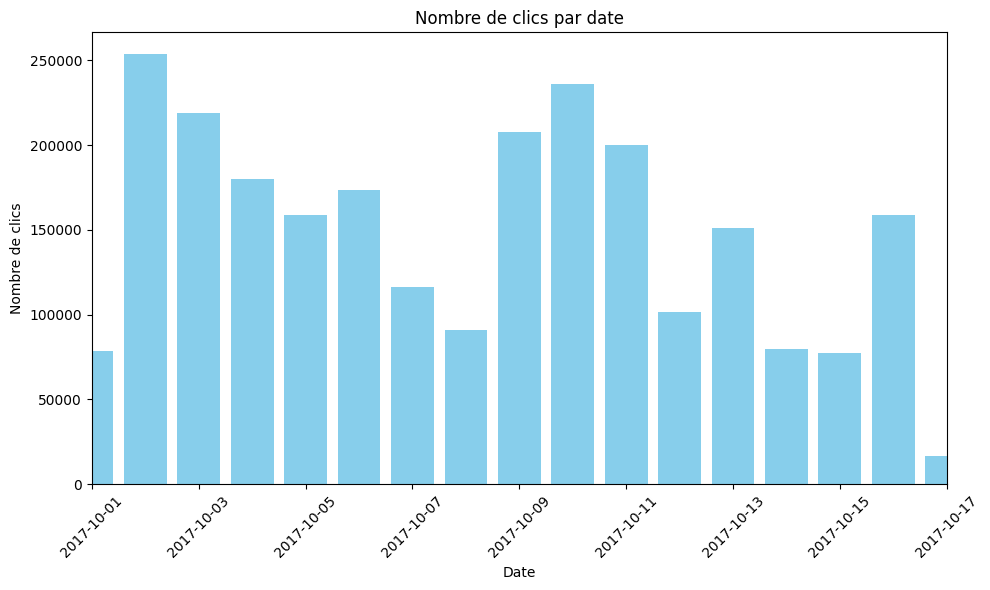

In [27]:
# Définir un seuil minimum de clics
seuil_minimum_clics = 1000  # Modifier selon vos besoins

# Filtrer les dates avec un nombre de clics supérieur au seuil minimum
dates_significatives = clicks_per_date[clicks_per_date['clicks'] >= seuil_minimum_clics]['click_date']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(clicks_per_date['click_date'], clicks_per_date['clicks'], color='skyblue')
plt.title('Nombre de clics par date')
plt.xlabel('Date')
plt.ylabel('Nombre de clics')
plt.xticks(rotation=45)
plt.xlim(dates_significatives.min(), dates_significatives.max())
plt.tight_layout()
plt.show()

### Le nombre de clics par utilisateur

In [28]:
# Group by 'user' and count the clicks
clicks_per_user = merged_data_V3.groupby('user_id').size().reset_index(name='clicks')
clicks_per_user

,user_id,clicks
0,0,6
1,1,9
2,2,3
3,3,15
4,4,6
...,...,...
320055,322892,2
320056,322893,2
320057,322894,2
320058,322895,2


In [29]:
clicks_per_user

,user_id,clicks
0,0,6
1,1,9
2,2,3
3,3,15
4,4,6
...,...,...
320055,322892,2
320056,322893,2
320057,322894,2
320058,322895,2


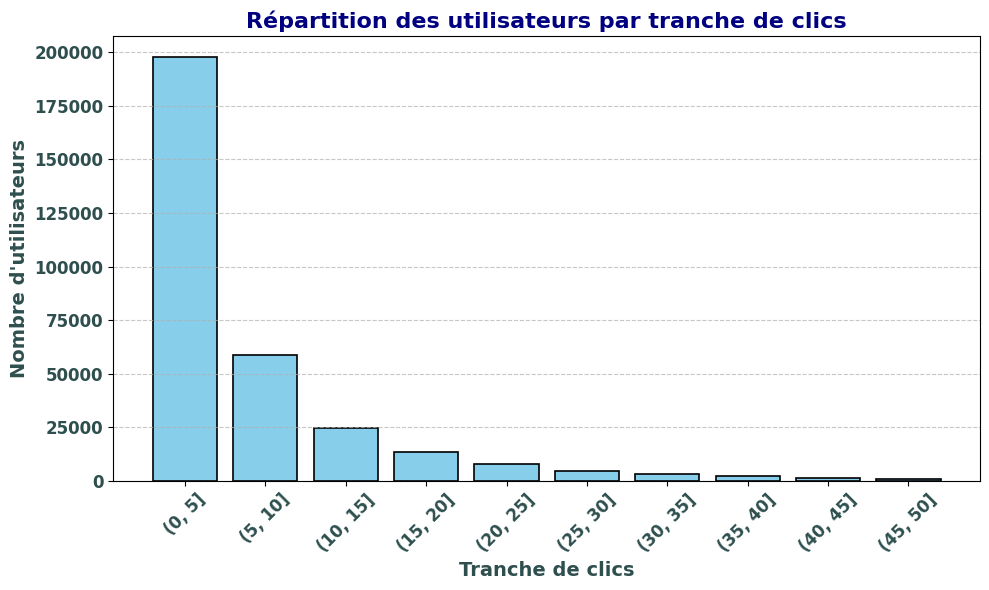

In [30]:
# Définir les intervalles pour les tranches de clics
intervals = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Utiliser pd.cut pour regrouper les utilisateurs en fonction du nombre de clics
clicks_per_user['clicks_interval'] = pd.cut(clicks_per_user['clicks'], bins=intervals)

# Compter le nombre d'utilisateurs dans chaque tranche
user_counts = clicks_per_user['clicks_interval'].value_counts().sort_index()

# Création du graphique à barre
plt.figure(figsize=(10, 6))
plt.bar(user_counts.index.astype(str), user_counts.values, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Répartition des utilisateurs par tranche de clics', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Tranche de clics', fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel('Nombre d\'utilisateurs', fontsize=14, fontweight='bold', color='darkslategray')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', color='darkslategray')
plt.yticks(fontsize=12, fontweight='bold', color='darkslategray')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Le nombre de clics par article

In [31]:
# Group by 'article' and count the clicks
clicks_per_article = merged_data_V3.groupby('article_id').size().reset_index(name='clicks')
clicks_per_article

,article_id,clicks
0,3,1
1,27,1
2,69,1
3,81,1
4,84,1
...,...,...
41790,364017,19
41791,364022,1
41792,364028,1
41793,364043,7


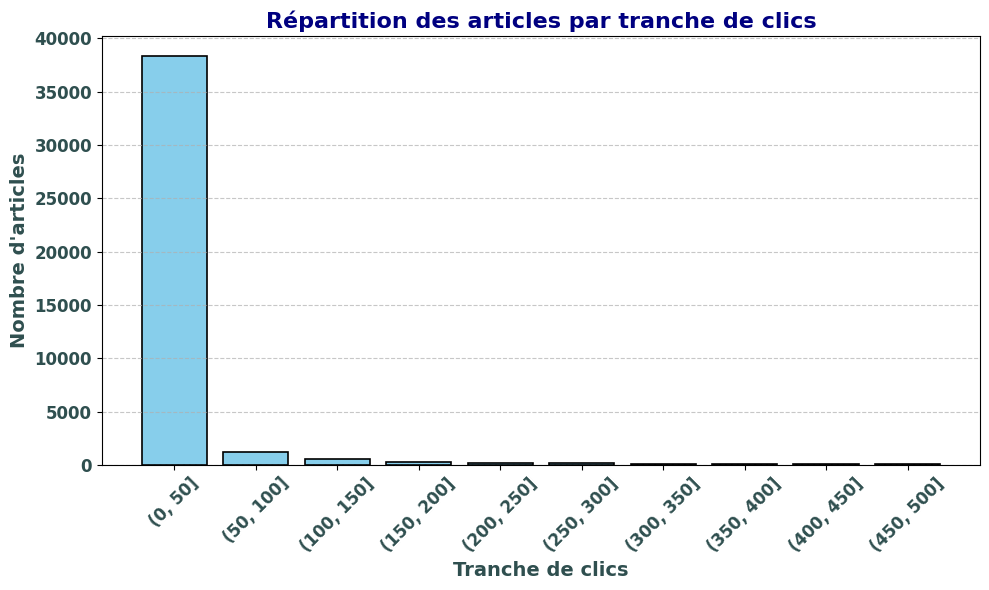

In [32]:
# Définir les intervalles pour les tranches de clics
intervals = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# Utiliser pd.cut pour regrouper les articles en fonction du nombre de clics dans ces intervalles
clicks_per_article['clicks_interval'] = pd.cut(clicks_per_article['clicks'], bins=intervals)

# Compter le nombre d'articles dans chaque tranche
article_counts = clicks_per_article['clicks_interval'].value_counts().sort_index()

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.bar(article_counts.index.astype(str), article_counts.values, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Répartition des articles par tranche de clics', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Tranche de clics', fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel('Nombre d\'articles', fontsize=14, fontweight='bold', color='darkslategray')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', color='darkslategray')
plt.yticks(fontsize=12, fontweight='bold', color='darkslategray')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

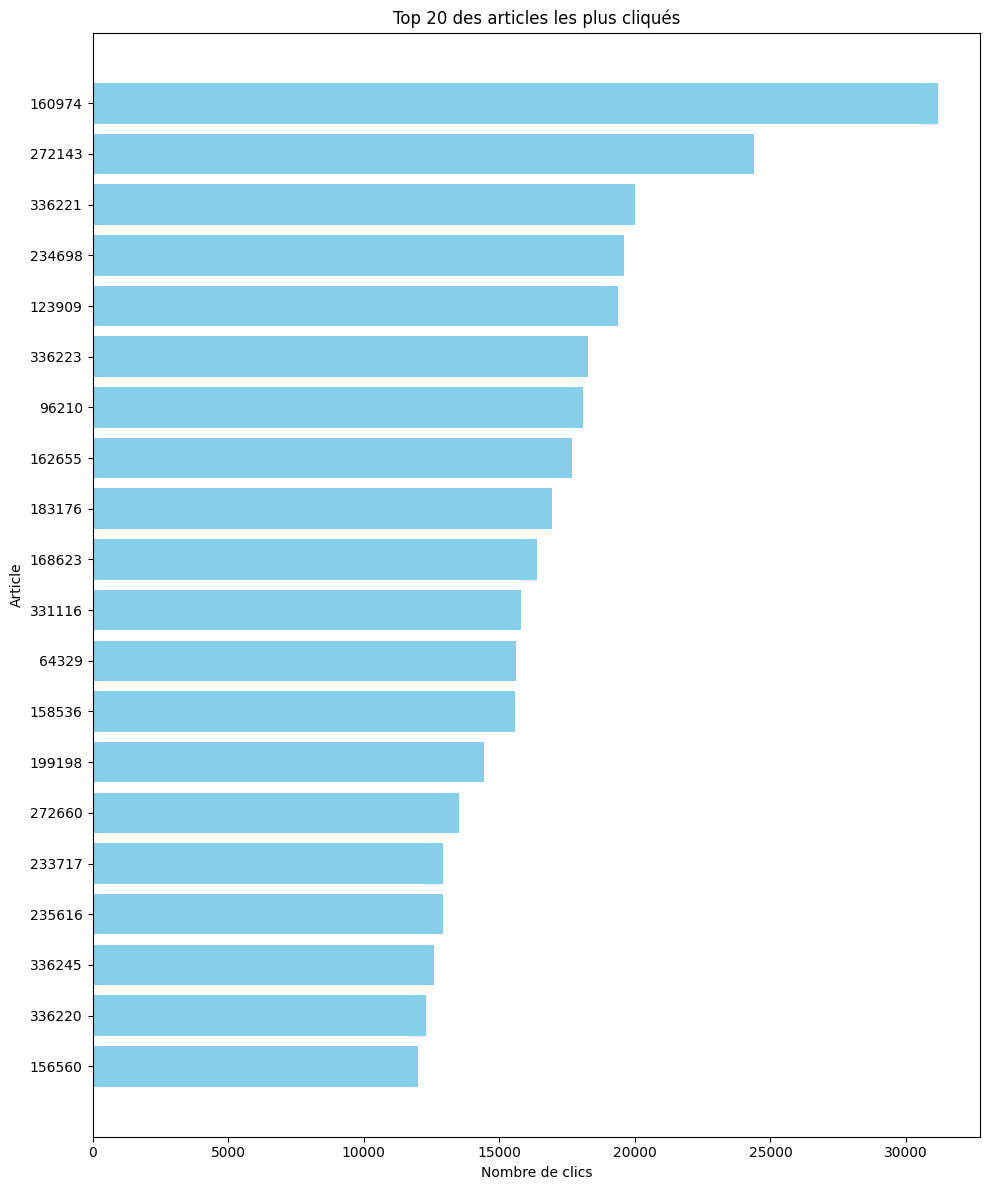

In [33]:
# Trier le DataFrame pour obtenir les 50 articles les plus cliqués
top_20_articles = clicks_per_article.sort_values(by='clicks', ascending=False).head(20)
# Convertir les identifiants d'articles en chaînes de caractères
top_20_articles['article_id'] = top_20_articles['article_id'].astype(str)

# Créer un graphique à barres horizontal
plt.figure(figsize=(10, 12))
plt.barh(top_20_articles['article_id'], top_20_articles['clicks'], color='skyblue')
plt.xlabel('Nombre de clics')
plt.ylabel('Article')
plt.title('Top 20 des articles les plus cliqués')
plt.gca().invert_yaxis()  # Inverser l'ordre des articles pour afficher le plus cliqué en haut
plt.tight_layout()
plt.show()

In [34]:
# Grouper les données par article et par utilisateur, en prenant la date de clic la plus récente
merged_data_V3['click_date'] = merged_data_V3['click_date'].dt.strftime('%Y-%m-%d %H:%M:%S')
latest_clicks = merged_data_V3.groupby(['article_id', 'user_id'])['click_date'].max().reset_index(name='latest_click_date')
latest_clicks

,article_id,user_id,latest_click_date
0,3,246630,2017-10-09 18:06:18
1,27,58062,2017-10-04 19:21:06
2,69,289974,2017-10-12 18:14:29
3,81,65902,2017-10-02 14:24:48
4,84,190073,2017-10-09 14:48:05
...,...,...,...
2473329,364043,205001,2017-10-06 16:49:28
2473330,364043,222064,2017-10-09 16:17:10
2473331,364043,277901,2017-10-11 15:22:10
2473332,364043,317423,2017-10-16 14:12:26


In [35]:
# On regroupe le nombre de clics par article et par utilisateur
df_grouped = merged_data_V3.groupby(['article_id', 'user_id'])['session_id'].count().reset_index(name='clicks')
df_grouped

,article_id,user_id,clicks
0,3,246630,1
1,27,58062,1
2,69,289974,1
3,81,65902,1
4,84,190073,1
...,...,...,...
2473329,364043,205001,1
2473330,364043,222064,1
2473331,364043,277901,1
2473332,364043,317423,1


In [36]:
# Fusionner les données agrégées avec le DataFrame df_grouped d'origine
df_grouped = pd.merge(df_grouped, latest_clicks, on=['article_id', 'user_id'], how='left')
df_grouped

,article_id,user_id,clicks,latest_click_date
0,3,246630,1,2017-10-09 18:06:18
1,27,58062,1,2017-10-04 19:21:06
2,69,289974,1,2017-10-12 18:14:29
3,81,65902,1,2017-10-02 14:24:48
4,84,190073,1,2017-10-09 14:48:05
...,...,...,...,...
2473329,364043,205001,1,2017-10-06 16:49:28
2473330,364043,222064,1,2017-10-09 16:17:10
2473331,364043,277901,1,2017-10-11 15:22:10
2473332,364043,317423,1,2017-10-16 14:12:26


In [37]:
df_grouped[df_grouped['user_id'] == 159994]

,article_id,user_id,clicks,latest_click_date
498038,111210,159994,1,2017-10-04 15:21:31
786971,156723,159994,1,2017-10-05 15:45:32
927962,160453,159994,1,2017-10-05 15:46:02
1082864,168623,159994,1,2017-10-05 15:42:30
1850556,276970,159994,1,2017-10-05 15:32:05
1930986,284452,159994,1,2017-10-04 15:22:01
2002559,285591,159994,1,2017-10-05 15:36:55
2065823,289003,159994,1,2017-10-16 12:38:32
2212294,313548,159994,1,2017-10-16 12:54:36
2226680,315104,159994,1,2017-10-16 12:52:00


In [38]:
# Compter le nombre d'occurrences de chaque nombre de clics
clicks_summary = df_grouped['clicks'].value_counts().reset_index()
clicks_summary.columns = ['number_of_clicks', 'count']
# Trier les résultats par nombre de clics pour une meilleure lisibilité
clicks_summary = clicks_summary.sort_values('number_of_clicks').reset_index(drop=True)

# Afficher le résumé
print(clicks_summary)

    number_of_clicks    count
0                  1  2449029
1                  2    22707
2                  3     1243
3                  4      216
4                  5       70
5                  6       31
6                  7        9
7                  8        9
8                  9        5
9                 10        4
10                11        1
11                12        2
12                13        1
13                14        2
14                25        1
15                26        3
16                29        1


### Préparation du dataframe pour calculer la métrique coût métier
- On filtre sur les users qui ont cliqué sur plusieurs articles différents
- On choisis seulement 100 utilisateurs aléatoirement

In [39]:
# Calculer le nombre d'articles différents cliqués par chaque utilisateur
user_article_counts = df_grouped.groupby('user_id')['article_id'].nunique()

# Filtrer les utilisateurs ayant cliqué sur au moins 2 articles différents
eligible_users = user_article_counts[user_article_counts >= 3].index

# Filtrer le DataFrame original pour ne garder que ces utilisateurs
df_eligible = df_grouped[df_grouped['user_id'].isin(eligible_users)]
df_eligible

,article_id,user_id,clicks,latest_click_date
1,27,58062,1,2017-10-04 19:21:06
2,69,289974,1,2017-10-12 18:14:29
4,84,190073,1,2017-10-09 14:48:05
5,94,5336,1,2017-10-15 12:13:13
6,94,289480,1,2017-10-12 18:37:56
...,...,...,...,...
2473326,364043,593,1,2017-10-07 17:07:14
2473327,364043,19864,1,2017-10-05 19:17:25
2473328,364043,106368,1,2017-10-06 22:46:44
2473330,364043,222064,1,2017-10-09 16:17:10


In [40]:
eligible_users

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
           10,
       ...
       322760, 322771, 322776, 322781, 322823, 322855, 322856, 322858, 322862,
       322879],
      dtype='int64', name='user_id', length=206223)

In [41]:
# Sélectionner 500 ou 1000 utilisateurs aléatoirement
random_users = np.random.choice(eligible_users, 1000, replace=False)

# Filtrer le DataFrame pour ne garder que ces utilisateurs aléatoires
df_sampled = df_eligible[df_eligible['user_id'].isin(random_users)]
df_sampled

,article_id,user_id,clicks,latest_click_date
158,1873,41781,1,2017-10-15 02:04:40
591,2075,93746,1,2017-10-02 20:29:06
692,2136,532,1,2017-10-01 20:00:06
723,2137,11213,1,2017-10-01 14:21:29
876,2256,60726,1,2017-10-06 21:27:01
...,...,...,...,...
2472041,363188,303831,1,2017-10-14 10:24:51
2472815,363916,83232,1,2017-10-16 18:57:11
2472906,363916,155588,1,2017-10-16 18:06:44
2472916,363916,165087,1,2017-10-16 19:36:11


# Réalisation d'une ACP (Analyse en Composantes Principales)

### Affichage de l'éboulis des valeurs propres pour choisir le nombre de composant dans l'ACP

In [42]:
# La réduction dimensionnelle est sur l'embedding
# Réaliser un fit transforms avec les résultat (remplace mon data sample)

In [43]:
data_acp = articles_embeddings.copy()

In [44]:
# Centrage et Réduction
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(articles_embeddings)

In [45]:
# Calcul des composantes principales
pca = decomposition.PCA()
pca.fit(X_scaled)

PCA()

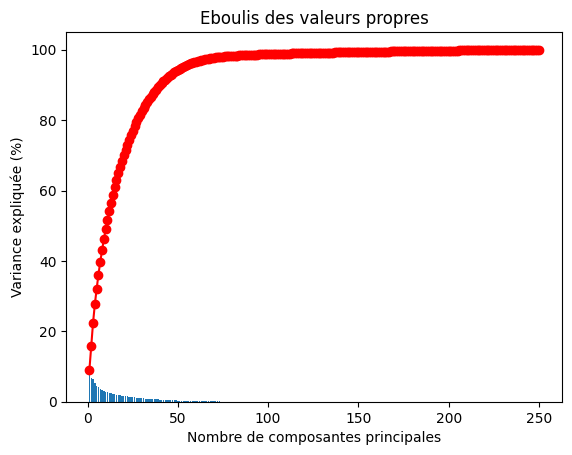

In [46]:
display_scree_plot(pca)

In [47]:
# Pour choisir le nombre de composant on se fixe un seuil de variance de 80% dans notre cas
# Calcul de la variance cumulée
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes nécessaires pour atteindre 80% de variance
n_components_80_variance = np.argmax(cumulative_variance_ratio >= 0.8) + 1

print("Nombre de composantes pour expliquer 80% de la variance :", n_components_80_variance)

Nombre de composantes pour expliquer 80% de la variance : 28


In [48]:
# choix du nombre de composantes à calculer (Trouvé grâce à l'éboulis des valeurs propres)
n_comp = 28

In [49]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=28)

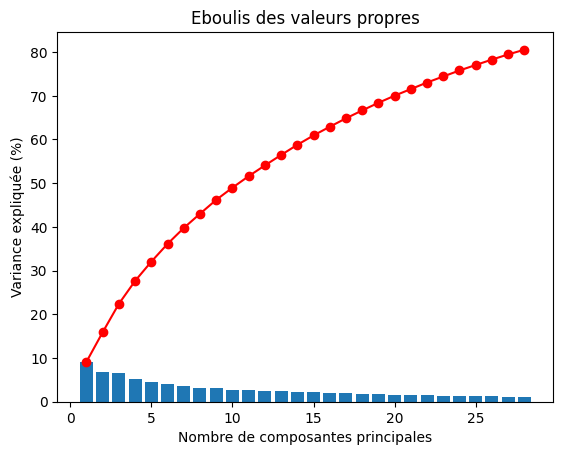

In [50]:
# Eboulis des valeurs propres
display_scree_plot(pca)

In [51]:
articles_embeddings_pca = pca.transform(X_scaled)
articles_embeddings_pca.shape
# C'est cette données que je vais ensuite utiliser dans mon content based

(364047, 28)

# Recommender systems "Content-Based"

In [52]:
# Tentative diminution du jeu de donnée de la matrice numpy contenant les embeddings des articles
#n_samples = 10000

# Sélection aléatoire des indices de lignes
#sampled_indices = np.random.choice(articles_embeddings.shape[0], size=n_samples, replace=False)

# Utilisation des indices échantillonnés pour sélectionner les lignes correspondantes dans la matrice
#sampled_data = articles_embeddings[sampled_indices, :]

In [53]:
def last_clicked_article(user_id, df):
    user_interactions = df[df['user_id'] == user_id].sort_values(by='latest_click_date', ascending=False)
    # Prendre seulement le dernier article cliqué
    last_clicked_article = user_interactions.iloc[0]['article_id']
    return last_clicked_article

def recommend_for_user(user_id, num, df):
    article_id = last_clicked_article(user_id, df)
    all_recommendations = []
    all_probabilities = []
    user_article = article_id
    # Calculate recommendations and probabilities for each article in the user profile
    recommendations, probabilities = recommend_for_article(article_id, num)
    all_recommendations.append(recommendations)
    all_probabilities.append(probabilities)
    return all_recommendations, all_probabilities, user_article

def recommend_for_article(article_id, num):
    recs = {}
    # Calculate similarity between user profile and each article
    similarity = cosine_similarity([articles_embeddings_pca[article_id]],articles_embeddings_pca)
    recs = similarity[0]
    # On récupère les $num meilleurs recommandations 
    # On exclu la première valeur car c'est l'article lui même on n'utilise pas np.delete pour ne pas enlever un index et modifer les suivants
    ids = np.argsort(recs)[::-1][1:num+1]  
    probabilities = recs[ids]
    return ids, probabilities

In [54]:
# Example of recommending articles for a user
user_id = 138038
num_recommendations = 5
recommendations, probabilities, user_article = recommend_for_user(user_id, num_recommendations, df_grouped)
print("Recommandations pour l'utilisateur", user_id)
# Boucle pour parcourir chaque article du profil utilisateur
# Pouvoir filtrer sur seulement le dernier article qu'il a cliqué
print(f"Recommandations pour le dernier article {user_article}:")
# Afficher les 5 meilleures recommandations pour le dernier article cliqué par l'utilisateur
for rec, prob in zip(recommendations, probabilities):
    for article_id, sim in zip(rec, prob):
        print(f"   Article: {article_id}, Similitude: {sim}")

Recommandations pour l'utilisateur 138038
Recommandations pour le dernier article 336574:
   Article: 333219, Similitude: 0.9720821380615234
   Article: 336575, Similitude: 0.9637004733085632
   Article: 337233, Similitude: 0.9628030061721802
   Article: 337283, Similitude: 0.9617894887924194
   Article: 336425, Similitude: 0.9604662656784058


### Calcul de la métrique coût métier pour le modèle content based

In [55]:
# Initialiser une liste pour stocker les résultats
results = []

# Nombre de recommandations à générer
num_recommendations = 5

# Obtenir les prédictions pour chaque utilisateur
for user_id in random_users:
    recommendations, probabilities, user_article = recommend_for_user(user_id, num_recommendations, df_grouped)
    for i in range(len(recommendations)):
        results.append({
            'user_id': user_id,
            'recommended_article': recommendations[i],
            'probability': probabilities[i],
        })

# Convertir les résultats en DataFrame
df_predictions = pd.DataFrame(results)
# Créer un DataFrame de départ
df_predictions_content = df_predictions.explode(['recommended_article', 'probability'])
df_predictions_content = df_predictions_content.reset_index(drop=True)

# Afficher le DataFrame
print(df_predictions_content)

      user_id recommended_article probability
0      200329              333494    0.937323
1      200329              336594     0.92834
2      200329              338013    0.928106
3      200329              333636    0.926918
4      200329              336179    0.924722
...       ...                 ...         ...
4995    98992               15050    0.968596
4996    98992               15020    0.965387
4997    98992               15195    0.964111
4998    98992               15130    0.961129
4999    98992               15610    0.958761

[5000 rows x 3 columns]


In [56]:
# Ajouter une colonne pour indiquer si un article recommandé a déjà été cliqué
df_predictions_content['already_clicked'] = 0

# Initialisation de la métrique coût métier
total_cost_metric = 0

# Vérifier pour chaque utilisateur si un article recommandé a déjà été cliqué
for index, row in df_predictions_content.iterrows():
    user_id = row['user_id']
    recommended_article = row['recommended_article']
    clicked_articles = df_grouped[df_grouped['user_id'] == user_id]['article_id'].tolist()
    
    # Vérifier si l'article recommandé a déjà été cliqué
    if recommended_article in clicked_articles:
        df_predictions_content.at[index, 'already_clicked'] = 1
        total_cost_metric += 1

print(f'Métrique de coût métier (count) : {total_cost_metric}')

Métrique de coût métier (count) : 11


In [57]:
df_predictions_content[df_predictions_content['already_clicked'] == 1]

,user_id,recommended_article,probability,already_clicked
22,50903,123290,0.859002,1
376,143222,284547,0.942577,1
548,33081,337051,0.948201,1
821,124741,123368,0.860717,1
905,60804,288320,0.958954,1
2161,79991,124350,0.859002,1
2717,56169,160974,0.893773,1
3985,65577,4178,0.994465,1
3991,40557,317895,0.91953,1
4060,121061,195032,0.968652,1


# Recommender systems "Collaborative filtering"

In [58]:
from surprise import Reader, Dataset, SVD, accuracy, KNNBasic, BaselineOnly
from surprise.model_selection import train_test_split

In [59]:
# Définir les seuils pour normaliser les clics en une échelle de 1 à 5
def map_clicks_to_ratings(clicks):
    if clicks == 1:
        return 1
    elif clicks <= 2:
        return 2
    elif clicks <= 4:
        return 3
    elif clicks <= 10:
        return 4
    else:
        return 5

In [60]:
# Appliquer la fonction de mappage
df_grouped['rating'] = df_grouped['clicks'].apply(map_clicks_to_ratings)
df_grouped

,article_id,user_id,clicks,latest_click_date,rating
0,3,246630,1,2017-10-09 18:06:18,1
1,27,58062,1,2017-10-04 19:21:06,1
2,69,289974,1,2017-10-12 18:14:29,1
3,81,65902,1,2017-10-02 14:24:48,1
4,84,190073,1,2017-10-09 14:48:05,1
...,...,...,...,...,...
2473329,364043,205001,1,2017-10-06 16:49:28,1
2473330,364043,222064,1,2017-10-09 16:17:10,1
2473331,364043,277901,1,2017-10-11 15:22:10,1
2473332,364043,317423,1,2017-10-16 14:12:26,1


In [61]:
# Filtrer les lignes où le rating est supérieur à 2
#filtered_df = df_grouped[df_grouped['clicks'] >= 3]
#filtered_df

In [62]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_grouped[['user_id', 'article_id', 'rating']], reader)

In [63]:
trainset, testset = train_test_split(data, test_size=0.25)

In [64]:
# On initialise le tableau comparatif
tab_compare = []

## Recommender systems with surprise (SVD)

In [65]:
# algorithme de recommandation, SVD (Singular Value Decomposition), pour entraîner le modèle sur les données d'entraînement
algo_SVD = SVD()
start_train = time()
algo_SVD.fit(trainset)
training_time = time() - start_train

In [66]:
start_eval = time()
predictions_SVD = algo_SVD.test(testset)
eval_time = time() - start_eval
predictions_SVD

[Prediction(uid=61228, iid=206402, r_ui=1.0, est=1.0617018543144512, details={'was_impossible': False}),
 Prediction(uid=40873, iid=160142, r_ui=1.0, est=1.012570887317288, details={'was_impossible': False}),
 Prediction(uid=3825, iid=277492, r_ui=1.0, est=1.0041877130299253, details={'was_impossible': False}),
 Prediction(uid=87981, iid=205973, r_ui=1.0, est=1, details={'was_impossible': False}),
 Prediction(uid=178486, iid=156355, r_ui=1.0, est=1.0018852600158907, details={'was_impossible': False}),
 Prediction(uid=270069, iid=234698, r_ui=1.0, est=1, details={'was_impossible': False}),
 Prediction(uid=15497, iid=207982, r_ui=1.0, est=1.3271162538001848, details={'was_impossible': False}),
 Prediction(uid=48177, iid=59758, r_ui=1.0, est=1.037737823088312, details={'was_impossible': False}),
 Prediction(uid=55338, iid=166282, r_ui=1.0, est=1, details={'was_impossible': False}),
 Prediction(uid=261869, iid=158541, r_ui=1.0, est=1.0194246579101296, details={'was_impossible': False}),
 P

In [67]:
# Parcourir chaque prédiction pour trouver celle avec l'iid recherchée
for prediction_SVD in predictions_SVD:
    if prediction_SVD.uid == 23:
        # Afficher la prédiction correspondante
        print("Prédiction trouvée :", prediction_SVD)
        break
else:
    print("Aucune prédiction avec l'uid recherchée n'a été trouvée.")

Prédiction trouvée : user: 23         item: 215613     r_ui = 1.00   est = 1.00   {'was_impossible': False}


In [68]:
score_RMSE_SVD = accuracy.rmse(predictions_SVD)
score_RMSE_SVD

RMSE: 0.1090


0.10898999486567514

In [69]:
# Définir l'ID de l'utilisateur cible
target_user_id = 23

In [70]:
# Obtenir les IDs de tous les articles
all_article_ids = df_grouped['article_id'].unique()

# Convertir le NumPy Array en DataFrame
df_all_articles_ids = pd.DataFrame(all_article_ids, columns=['article_id'])

# Sauvegarder en CSV
df_all_articles_ids.to_csv('all_article_ids.csv', index=False)
all_article_ids

array([     3,     27,     69, ..., 364028, 364043, 364046], dtype=int64)

In [71]:
# Générer les prédictions pour l'utilisateur cible
# uid correspond à l'utilisateur id et iid correspond à l'article id
predictions_user_SVD = [algo_SVD.predict(target_user_id, article_id) for article_id in all_article_ids]
# Trier les prédictions par note estimée (Top 5)
top_predictions_SVD = sorted(predictions_user_SVD, key=lambda x: x.est, reverse=True)[:5]

In [72]:
# Afficher les résultats
print("Top 5 des articles recommandés pour l'utilisateur", target_user_id, ":")
for i, pred in enumerate(top_predictions_SVD, 1):
    print(f"{i}. Article ID: {pred.iid}, Rating: {pred.est}")

Top 5 des articles recommandés pour l'utilisateur 23 :
1. Article ID: 363925, Rating: 1.5432894922596905
2. Article ID: 337479, Rating: 1.493386982993833
3. Article ID: 218143, Rating: 1.4355425552978243
4. Article ID: 285434, Rating: 1.4271003685913024
5. Article ID: 146230, Rating: 1.4080737901843374


### Calcul de la métrique coût métier pour le modèle Collaborative filtering avec SVD

In [73]:
# Initialiser une liste pour stocker les résultats
results = []

# Nombre de recommandations à générer
num_recommendations = 5

# Obtenir les prédictions pour chaque utilisateur
for user_id in random_users:
    predictions_user = [algo_SVD.predict(user_id, article_id) for article_id in all_article_ids]
    recommendations = sorted(predictions_user, key=lambda x: x.est, reverse=True)[:5]
    for i, pred in enumerate(recommendations, 1):
        results.append({
            'user_id': user_id,
            'recommended_article': pred.iid,
            'probability': pred.est,
        })

# Convertir les résultats en DataFrame
df_predictions = pd.DataFrame(results)
# Créer un DataFrame de départ
df_predictions_SVD = df_predictions.explode(['recommended_article', 'probability'])
df_predictions_SVD = df_predictions_SVD.reset_index(drop=True)

# Afficher le DataFrame
print(df_predictions_SVD)

      user_id  recommended_article  probability
0      200329               146230     1.524227
1      200329               261672     1.492559
2      200329               225471     1.466445
3      200329               106783     1.439084
4      200329                58800     1.413332
...       ...                  ...          ...
4995    98992                56461     1.463700
4996    98992                 8239     1.430946
4997    98992               105941     1.415779
4998    98992               340605     1.413765
4999    98992                20511     1.392652

[5000 rows x 3 columns]


In [74]:
# Ajouter une colonne pour indiquer si un article recommandé a déjà été cliqué
df_predictions_SVD['already_clicked'] = 0

# Initialisation de la métrique coût métier
total_cost_metric = 0

# Vérifier pour chaque utilisateur si un article recommandé a déjà été cliqué
for index, row in df_predictions_SVD.iterrows():
    user_id = row['user_id']
    recommended_article = row['recommended_article']
    clicked_articles = df_grouped[df_grouped['user_id'] == user_id]['article_id'].tolist()
    
    # Vérifier si l'article recommandé a déjà été cliqué
    if recommended_article in clicked_articles:
        df_predictions_SVD.at[index, 'already_clicked'] = 1
        total_cost_metric += 1

print(f'Métrique de coût métier (count) : {total_cost_metric}')

Métrique de coût métier (count) : 0


In [75]:
df_predictions_SVD[df_predictions_SVD['already_clicked'] == 1]

,user_id,recommended_article,probability,already_clicked


In [76]:
# Insertion du score d'évaluation pour le modèle SVD
tab_compare.append(['SVD', score_RMSE_SVD, training_time, eval_time, total_cost_metric])

## Recommender systems with surprise (KNN)

In [77]:
# Utiliser la similarité cosine
# Le problème de se modèle est qu'il demande beaucoup de ressources (User based = False)
sim_options = {'name': 'cosine', 'user_based': False}  # False pour item-based, True pour user-based
algo_KNN = KNNBasic(sim_options=sim_options)
# Entraîner le modèle sur l'ensemble de formation
start_train = time()
algo_KNN.fit(trainset)
training_time = time() - start_train

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [78]:
# Tester le modèle sur l'ensemble de test
start_eval = time()
predictions_KNN = algo_KNN.test(testset)
eval_time = time() - start_eval
predictions_KNN

[Prediction(uid=61228, iid=206402, r_ui=1.0, est=1, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=40873, iid=160142, r_ui=1.0, est=1, details={'actual_k': 13, 'was_impossible': False}),
 Prediction(uid=3825, iid=277492, r_ui=1.0, est=1, details={'actual_k': 39, 'was_impossible': False}),
 Prediction(uid=87981, iid=205973, r_ui=1.0, est=1, details={'actual_k': 13, 'was_impossible': False}),
 Prediction(uid=178486, iid=156355, r_ui=1.0, est=1, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid=270069, iid=234698, r_ui=1.0, est=1, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=15497, iid=207982, r_ui=1.0, est=1.175, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=48177, iid=59758, r_ui=1.0, est=1.0484803923250372, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=55338, iid=166282, r_ui=1.0, est=1, details={'actual_k': 15, 'was_impossible': False}),
 Prediction(uid=261869, iid=158541, r_ui=1.0, 

In [79]:
# Parcourir chaque prédiction pour trouver celle avec l'iid recherchée
for prediction_KNN in predictions_KNN:
    if prediction_KNN.uid == 23:
        # Afficher la prédiction correspondante
        print("Prédiction trouvée :", prediction_KNN)
        break
else:
    print("Aucune prédiction avec l'uid recherchée n'a été trouvée.")

Prédiction trouvée : user: 23         item: 215613     r_ui = 1.00   est = 1.00   {'actual_k': 20, 'was_impossible': False}


In [80]:
# Évaluer la précision du modèle
score_RMSE_KNN = accuracy.rmse(predictions_KNN)
score_RMSE_KNN

RMSE: 0.1106


0.11063586210673468

In [81]:
# Générer les prédictions pour l'utilisateur cible
# uid correspond à l'utilisateur id et iid correspond à l'article id
predictions_user_KNN = [algo_KNN.predict(target_user_id, article_id) for article_id in all_article_ids]
# Trier les prédictions par note estimée (Top 5)
top_predictions_KNN = sorted(predictions_user_KNN, key=lambda x: x.est, reverse=True)[:5]

In [82]:
# Afficher les résultats
print("Top 5 des articles recommandés pour l'utilisateur", target_user_id, ":")
for i, pred in enumerate(top_predictions_KNN, 1):
    print(f"{i}. Article ID: {pred.iid}, Rating: {pred.est}")

Top 5 des articles recommandés pour l'utilisateur 23 :
1. Article ID: 3, Rating: 1.0106140161725068
2. Article ID: 27, Rating: 1.0106140161725068
3. Article ID: 69, Rating: 1.0106140161725068
4. Article ID: 81, Rating: 1.0106140161725068
5. Article ID: 84, Rating: 1.0106140161725068


### Calcul de la métrique coût métier pour le modèle Collaborative filtering avec KNN

In [83]:
# Initialiser une liste pour stocker les résultats
results = []

# Nombre de recommandations à générer
num_recommendations = 5

# Obtenir les prédictions pour chaque utilisateur
for user_id in random_users:
    predictions_user = [algo_KNN.predict(user_id, article_id) for article_id in all_article_ids]
    recommendations = sorted(predictions_user, key=lambda x: x.est, reverse=True)[:5]
    for i, pred in enumerate(recommendations, 1):
        results.append({
            'user_id': user_id,
            'recommended_article': pred.iid,
            'probability': pred.est,
        })

# Convertir les résultats en DataFrame
df_predictions = pd.DataFrame(results)
# Créer un DataFrame de départ
df_predictions_KNN = df_predictions.explode(['recommended_article', 'probability'])
df_predictions_KNN = df_predictions_KNN.reset_index(drop=True)

# Afficher le DataFrame
print(df_predictions_KNN)

      user_id  recommended_article  probability
0      200329                    3     1.010614
1      200329                   27     1.010614
2      200329                   69     1.010614
3      200329                   81     1.010614
4      200329                   84     1.010614
...       ...                  ...          ...
4995    98992                    3     1.010614
4996    98992                   27     1.010614
4997    98992                   69     1.010614
4998    98992                   81     1.010614
4999    98992                   84     1.010614

[5000 rows x 3 columns]


In [84]:
# Ajouter une colonne pour indiquer si un article recommandé a déjà été cliqué
df_predictions_KNN['already_clicked'] = 0

# Initialisation de la métrique coût métier
total_cost_metric = 0

# Vérifier pour chaque utilisateur si un article recommandé a déjà été cliqué
for index, row in df_predictions_KNN.iterrows():
    user_id = row['user_id']
    recommended_article = row['recommended_article']
    clicked_articles = df_grouped[df_grouped['user_id'] == user_id]['article_id'].tolist()
    
    # Vérifier si l'article recommandé a déjà été cliqué
    if recommended_article in clicked_articles:
        df_predictions_KNN.at[index, 'already_clicked'] = 1
        total_cost_metric += 1

print(f'Métrique de coût métier (count) : {total_cost_metric}')

Métrique de coût métier (count) : 6


In [85]:
df_predictions_KNN[df_predictions_KNN['already_clicked'] == 1]

,user_id,recommended_article,probability,already_clicked
1333,62367,160974,1.081405,1
4325,247853,20013,1.142857,1
4326,247853,62379,1.142857,1
4327,247853,156279,1.142857,1
4328,247853,161526,1.142857,1
4329,247853,172766,1.142857,1


In [86]:
# Insertion du score d'évaluation pour le modèle KNN
tab_compare.append(['KNN', score_RMSE_KNN, training_time, eval_time, total_cost_metric])

## Recommender systems with surprise (Base line only)

In [87]:
# Définir l'algorithme BaselineOnly
algo_BLO = BaselineOnly()
# Entraîner le modèle sur l'ensemble de formation
start_train = time()
algo_BLO.fit(trainset)
training_time = time() - start_train

Estimating biases using als...


In [88]:
# Tester le modèle sur l'ensemble de test
start_eval = time()
predictions_BLO = algo_BLO.test(testset)
eval_time = time() - start_eval
predictions_BLO

[Prediction(uid=61228, iid=206402, r_ui=1.0, est=1.0165847825422012, details={'was_impossible': False}),
 Prediction(uid=40873, iid=160142, r_ui=1.0, est=1.002964501688312, details={'was_impossible': False}),
 Prediction(uid=3825, iid=277492, r_ui=1.0, est=1.0014203140703102, details={'was_impossible': False}),
 Prediction(uid=87981, iid=205973, r_ui=1.0, est=1, details={'was_impossible': False}),
 Prediction(uid=178486, iid=156355, r_ui=1.0, est=1.0054750467966782, details={'was_impossible': False}),
 Prediction(uid=270069, iid=234698, r_ui=1.0, est=1.0136409967174238, details={'was_impossible': False}),
 Prediction(uid=15497, iid=207982, r_ui=1.0, est=1.2870527999156236, details={'was_impossible': False}),
 Prediction(uid=48177, iid=59758, r_ui=1.0, est=1.030865701055002, details={'was_impossible': False}),
 Prediction(uid=55338, iid=166282, r_ui=1.0, est=1, details={'was_impossible': False}),
 Prediction(uid=261869, iid=158541, r_ui=1.0, est=1.0201300586907591, details={'was_impossi

In [89]:
# Parcourir chaque prédiction pour trouver celle avec l'iid recherchée
for prediction_BLO in predictions_BLO:
    if prediction_BLO.uid == 23:
        # Afficher la prédiction correspondante
        print("Prédiction trouvée :", prediction_BLO)
        break
else:
    print("Aucune prédiction avec l'uid recherchée n'a été trouvée.")

Prédiction trouvée : user: 23         item: 215613     r_ui = 1.00   est = 1.00   {'was_impossible': False}


In [90]:
# Évaluer la précision du modèle
score_RMSE_BLO = accuracy.rmse(predictions_BLO)
score_RMSE_BLO

RMSE: 0.1052


0.10521519803851924

In [91]:
# Générer les prédictions pour l'utilisateur cible
# uid correspond à l'utilisateur id et iid correspond à l'article id
predictions_user_BLO = [algo_BLO.predict(target_user_id, article_id) for article_id in all_article_ids]
# Trier les prédictions par note estimée (Top 5)
top_predictions_BLO = sorted(predictions_user_BLO, key=lambda x: x.est, reverse=True)[:5]

In [92]:
# Afficher les résultats
print("Top 5 des articles recommandés pour l'utilisateur", target_user_id, ":")
for i, pred in enumerate(top_predictions_BLO, 1):
    print(f"{i}. Article ID: {pred.iid}, Rating: {pred.est}")

Top 5 des articles recommandés pour l'utilisateur 23 :
1. Article ID: 68851, Rating: 1.3450241871927324
2. Article ID: 237071, Rating: 1.3450241871927324
3. Article ID: 363925, Rating: 1.3166907953283409
4. Article ID: 105941, Rating: 1.310577769700827
5. Article ID: 206210, Rating: 1.274054721324336


### Calcul de la métrique coût métier pour le modèle Collaborative filtering avec Base Line Only

In [93]:
# Initialiser une liste pour stocker les résultats
results = []

# Nombre de recommandations à générer
num_recommendations = 5

# Obtenir les prédictions pour chaque utilisateur
for user_id in random_users:
    predictions_user = [algo_BLO.predict(user_id, article_id) for article_id in all_article_ids]
    recommendations = sorted(predictions_user, key=lambda x: x.est, reverse=True)[:5]
    for i, pred in enumerate(recommendations, 1):
        results.append({
            'user_id': user_id,
            'recommended_article': pred.iid,
            'probability': pred.est,
        })

# Convertir les résultats en DataFrame
df_predictions = pd.DataFrame(results)
# Créer un DataFrame de départ
df_predictions_BLO = df_predictions.explode(['recommended_article', 'probability'])
df_predictions_BLO = df_predictions_BLO.reset_index(drop=True)

# Afficher le DataFrame
print(df_predictions_BLO)

      user_id  recommended_article  probability
0      200329                68851     1.347829
1      200329               237071     1.347829
2      200329               363925     1.319496
3      200329               105941     1.313383
4      200329               206210     1.276860
...       ...                  ...          ...
4995    98992                68851     1.345269
4996    98992               237071     1.345269
4997    98992               363925     1.316935
4998    98992               105941     1.310822
4999    98992               206210     1.274299

[5000 rows x 3 columns]


In [94]:
# Ajouter une colonne pour indiquer si un article recommandé a déjà été cliqué
df_predictions_BLO['already_clicked'] = 0

# Initialisation de la métrique coût métier
total_cost_metric = 0

# Vérifier pour chaque utilisateur si un article recommandé a déjà été cliqué
for index, row in df_predictions_BLO.iterrows():
    user_id = row['user_id']
    recommended_article = row['recommended_article']
    clicked_articles = df_grouped[df_grouped['user_id'] == user_id]['article_id'].tolist()
    
    # Vérifier si l'article recommandé a déjà été cliqué
    if recommended_article in clicked_articles:
        df_predictions_BLO.at[index, 'already_clicked'] = 1
        total_cost_metric += 1

print(f'Métrique de coût métier (count) : {total_cost_metric}')

Métrique de coût métier (count) : 0


In [95]:
df_predictions_BLO[df_predictions_BLO['already_clicked'] == 1]

,user_id,recommended_article,probability,already_clicked


In [96]:
# Insertion du score d'évaluation pour le modèle Base line only
tab_compare.append(['Base line only', score_RMSE_BLO, training_time, eval_time, total_cost_metric])

### Comparaison des différents modèles

In [97]:
# On transforme tab_compare en dataframe 
df_tab_compare = pd.DataFrame(tab_compare, columns = ['Model testé', 'Score RMSE du modèle', 'Temps entraînement', 'Temps évaluation', 'Coût métier'])
df_tab_compare

,Model testé,Score RMSE du modèle,Temps entraînement,Temps évaluation,Coût métier
0,SVD,0.108990,23.350727,6.577954,0
1,KNN,0.110636,72.606969,20.961708,6
2,Base line only,0.105215,4.561353,3.706717,0


### Choix du meilleur modèle
Le modèle que je vais choisir comme meilleur modèle est **le modèle SVD** car il a un bon score RMSE **(0.110539)** comparés aux autres modèles.
Il a un temps d'entraînement correct **(21.32 sec)** et un bon temps d'évaluation **(6.099 sec)**.
Le modèle Base line only est un peu moins efficace, il a un score RMSE plus faible.
Le modèle KNN a un plus long temps de prédiction et temps d'entraînement, de plus le modèle KNN a besoin de beaucoup de ressources ce qui est bloquant si on veut l'utiliser avec un grand jeu de données 

In [98]:
# Save le modèle SVD 
# Sauvegarder le modèle dans un fichier
with open('svd_model.pkl', 'wb') as model_file:
    pickle.dump(algo_SVD, model_file)

In [99]:
# Tester des algos différents toujours avec la librairie Surprise si possible
# Tester un algorithme différent KNN
# Tester un algorithme différent Base line only
# Comparer sur le temps de prédiction etc et sur le score rmse 
# Commencer à travailler sur une azure fonction 